In [10]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import copy
from pathlib import Path
from importlib import reload  
import os.path as osp
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
sys.path.append(os.path.abspath(os.path.join('../')))
sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import plotting_utils.util_plotting as util_plt
reload(util_plt)

<module 'plotting_utils.util_plotting' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/Clustering/IDEC/plotting_utils/util_plotting.py'>

In [2]:
firon='' #
DATA_PATH='/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/files/AD_event_based/graph_data/validation/'
BG_NAME = 'background_validation_fixed.h5'
with h5py.File(DATA_PATH+BG_NAME,'r') as f:
    particles = np.array(f['Particles'],dtype=np.float32)
idx_jet_0,idx_jet_1=9,19


In [3]:
mask_single_jet = np.sum(particles[:,idx_jet_0:,-1],axis=1)==4

In [4]:
single_jets = np.sum(particles[mask_single_jet][:,idx_jet_0:idx_jet_1,:3],axis=1)


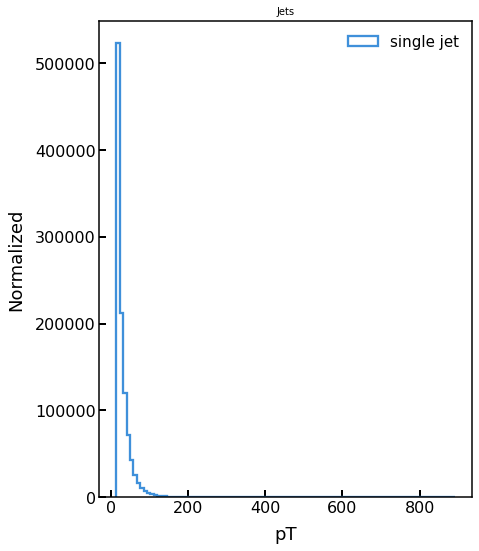

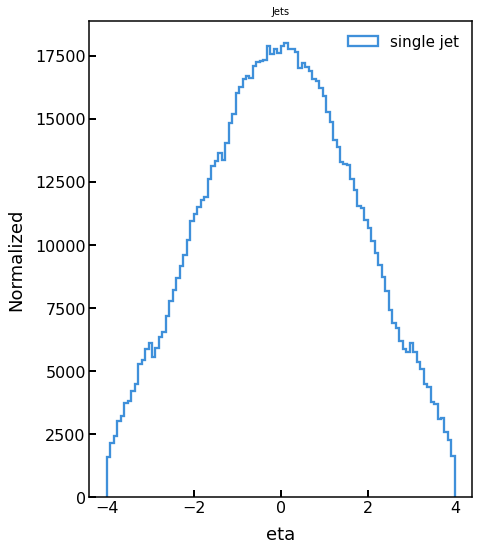

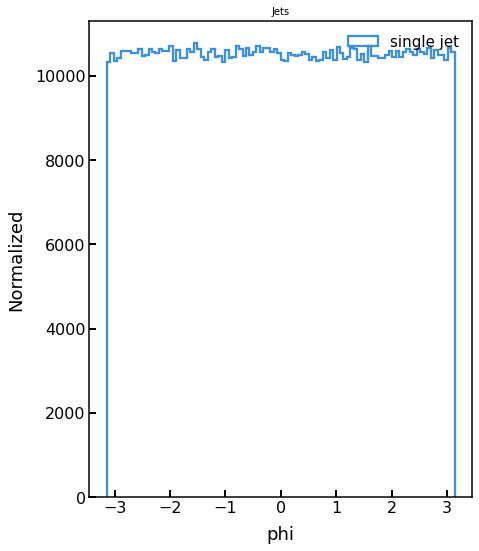

In [19]:
reload(util_plt)
util_plt.plot_features([single_jets], ['pT','eta','phi'],
                             'Normalized' , 'Jets', 
                             plotname='test',
                             legend=['single jet'],
                              ylogscale=False)
    

In [51]:
def gaussian_smear(pt,res=20.):
    idx_pt, idx_eta,idx_phi = 0,1,2
    pt[:,idx_pt] = pt[:,idx_pt]*np.where(pt[:,idx_pt]<200,
                                   1.0+np.random.normal(0.0, scale=0.2, size=len(pt[:,idx_pt])),
                                    1.0+np.random.normal(0.0, scale=res/pt[:,idx_pt], size=len(pt[:,idx_pt]))
                                    )
    
    pt[:,idx_phi] = -1*pt[:,idx_phi]*(1.0+np.random.normal(0.0, scale=0.01, size=len(pt[:,idx_phi])))
    pt[:,idx_eta] = 0.
    return pt

In [52]:
single_jets_smeared = copy.deepcopy(single_jets)

In [53]:
single_jets_smeared = gaussian_smear(single_jets_smeared)

No handles with labels found to put in legend.


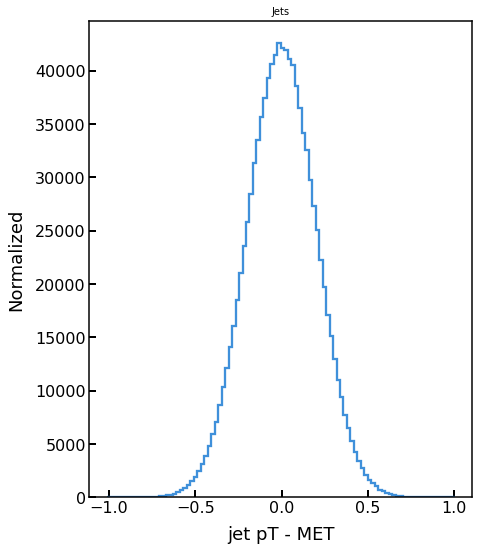

In [54]:
util_plt.plot_features([(single_jets[:,0:1]-single_jets_smeared[:,0:1])/single_jets[:,0:1]], ['jet pT - MET'] ,
                             'Normalized' , 'Jets', 
                             plotname='test',
                             legend=[''],
                              ylogscale=False)
    

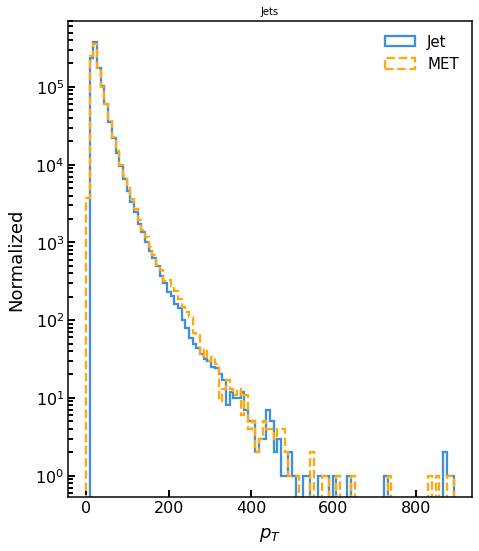

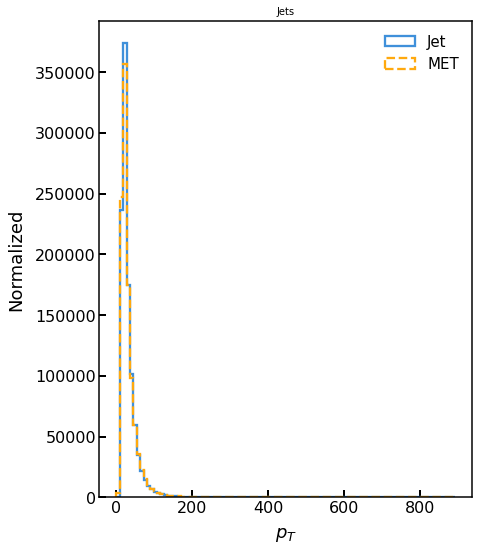

In [55]:
#bins = np.linspace(0,300,100)
#_ = plt.hist(single_jets[:,0:1],bins,histtype='step',linewidth=2)
#_ = plt.hist(single_jets_smeared[:,0:1],bins,histtype='step',linewidth=2)
#plt.semilogy()

util_plt.plot_features([single_jets[:,0:1],single_jets_smeared[:,0:1]], ['$p_{T}$'] ,
                             'Normalized' , 'Jets', 
                             plotname='test',
                             legend=['Jet','MET'],
                              ylogscale=True)
    
util_plt.plot_features([single_jets[:,0:1],single_jets_smeared[:,0:1]], ['$p_{T}$'] ,
                             'Normalized' , 'Jets', 
                             plotname='test',
                             legend=['Jet','MET'],
                              ylogscale=False)


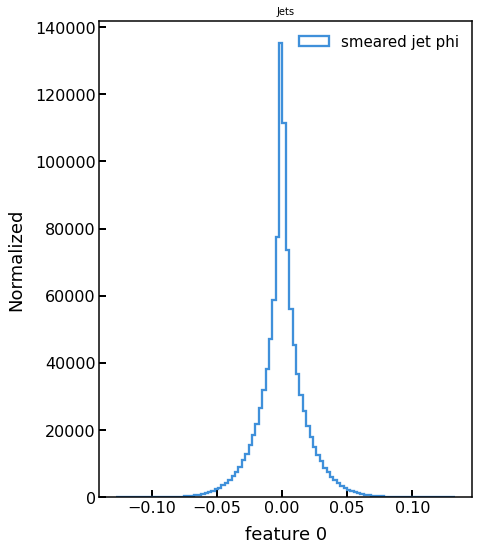

In [57]:
util_plt.plot_features([single_jets[:,2:3]+single_jets_smeared[:,2:3]], 'feature' ,
                             'Normalized' , 'Jets', 
                             plotname='test',
                             legend=['smeared jet phi'],
                             ylogscale=False)

In [92]:
met_plus_pid = np.concatenate([np.expand_dims(single_jets_smeared,axis=1),np.ones((single_jets_smeared.shape[0],1,1))],axis=-1)
jet_plus_pid = np.concatenate([np.expand_dims(single_jets,axis=1),4*np.ones((single_jets_smeared.shape[0],1,1))],axis=-1)

mono_jet_array = np.concatenate([met_plus_pid,
                                np.zeros((single_jets_smeared.shape[0],4,4)),
                                np.zeros((single_jets_smeared.shape[0],4,4)),
                                jet_plus_pid,
                                np.zeros((single_jets_smeared.shape[0],9,4))],
                                axis=1)
proc_ID = 34
true_labels = proc_ID*np.ones((single_jets_smeared.shape[0]))


In [93]:
outfile = DATA_PATH + 'sig_fake_monojet_fixed.h5'
with h5py.File(outfile, 'w') as handle:
    handle.create_dataset('Particles', data=mono_jet_array, compression='gzip')
    handle.create_dataset('ProcessID', data=true_labels, compression='gzip')
